Import necessary packages

In [1]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import os
import requests
import json
from bia_explorer import io, biostudies
import tempfile

Get study and display description

In [2]:
accession = 'S-BIAD463' 
subm = biostudies.load_submission(accession)
study_dict = biostudies.attributes_to_dict(subm.section.attributes)

from IPython.display import display, Markdown

attribute_html = ['<tr><td><b>{}</b></td><td style="text-align:left">{}</td></tr>'.format(k, v) for k, v in study_dict.items()]
display(Markdown('<table>{}</table>'.format("".join(attribute_html))))

<table><tr><td><b>Description</b></td><td style="text-align:left">Vascular remodeling is common in human cancer and has potential as future biomarkers for prediction of disease progression and tumor immunity status. It can also affect metastatic sites, including the tumor-draining lymph nodes (TDLNs). Dilation of the high endothelial venules (HEVs) within TDLNs has been observed in several types of cancer. We recently demonstrated that it is a pre-metastatic effect that can be linked to tumor invasiveness in breast cancer. Manual visual assessment of changes in vascular morphology is a tedious and difficult task, limiting high throughput analysis. Here we present a fully automated approach for detection and classification of HEV dilation. By using 12,524 manually classified HEVs, we trained a deep learning model and created a graphical user interface for visualization of the results. The tool, named the HEV-finder, selectively analyses HEV dilation in specific regions of the LN. We evaluate the HEV-finder’s ability to detect and classify HEV dilation in different types of breast cancer compared to manual annotations. Our results constitute a successful example of large-scale; fully automated and user-independent, image-based quantitative assessment of vascular remodeling in human pathology and lay the ground for future exploration of HEV dilation in TDLNs as a biomarker.</td></tr><tr><td><b>Study Type</b></td><td style="text-align:left">immunocytochemistry</td></tr><tr><td><b>Organism</b></td><td style="text-align:left">Homo sapiens (human)</td></tr><tr><td><b>Keywords</b></td><td style="text-align:left">segmentation</td></tr></table>

Load study images

In [3]:
study = io.load_bia_study(accession)

image_list = []
i = 0
for i in range(len(study.images)):
    image_list.append(study.images[i])

Get COCO annotations file

In [4]:
cocoann_uri = 'https://www.ebi.ac.uk/biostudies/files/S-BIAD463/my_submission/Training_coco/COCO_annotations.json'
response = requests.get(cocoann_uri)
annFile = response.json()

Create a temporary file to store COCO annotations

In [12]:
tempdir = tempfile.TemporaryDirectory()

with open(tempdir.name + '/COCO_annotations.json', 'a') as tf:
    json.dump(annFile, tf)

Initialise COCO API

In [6]:
coco = COCO(tempdir.name + '/COCO_annotations.json')

loading annotations into memory...
Done (t=1.43s)
creating index...
index created!


Delete temporary file

In [13]:
tempdir.cleanup()

Display COCO categories and supercategories

In [8]:
cats = coco.loadCats(coco.getCatIds())
nms = [cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
not dilated vessel Intermediately dilated vessel highly dilated vessel CCL21+

COCO supercategories: 
object tissue


Enter path to image of interest and display it

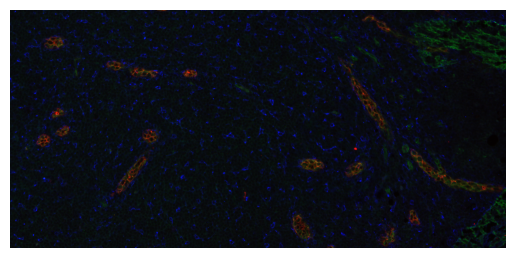

In [20]:
impath = 'my_submission/Training_coco/IDC with metastasis/Patient_033/9.png'

image = [f for f in image_list if str(f.fpath) == impath]
im = image[0].show_pil()
plt.axis('off')
plt.imshow(im)
plt.show()

To be able to load the corresponding annotations, we need to find the image ID. This is given in a set of files called annotations.json (one file per patient)

In [21]:
head_tail = os.path.split(impath)
idann_path = 'https://www.ebi.ac.uk/biostudies/files/S-BIAD463/'+ head_tail[0]+'/annotations.json'

response = requests.get(idann_path)
idann = response.json()
idann_dict = next(item for item in idann if item['file_name'] == head_tail[1])
image_id = idann_dict['id'] 

Load and display instance annotations using COCO API

IDC with metastasis/Patient_335/9.png


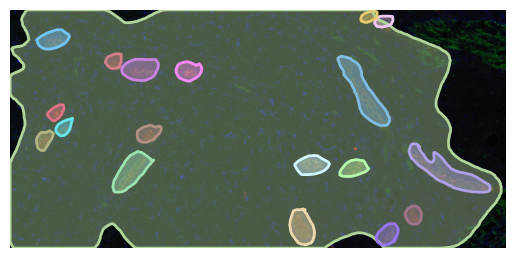

In [22]:
plt.imshow(im,cmap='gray', vmin=0, vmax=255); plt.axis('off')
annIds = coco.getAnnIds(imgIds=image_id, iscrowd=None)
img_info = coco.loadImgs([image_id])[0]
print(img_info["file_name"])
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

Load and display bounding boxes and segmentations using COCO API

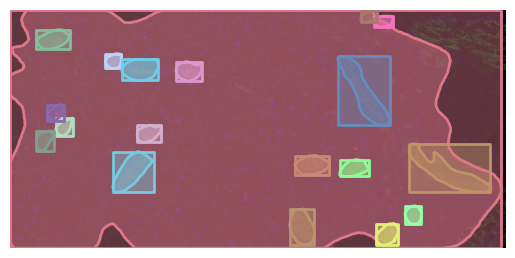

In [23]:
plt.imshow(im,cmap='gray', vmin=0, vmax=255); plt.axis('off')
coco.showAnns(anns, draw_bbox=True)

Load and display bounding boxes and classes

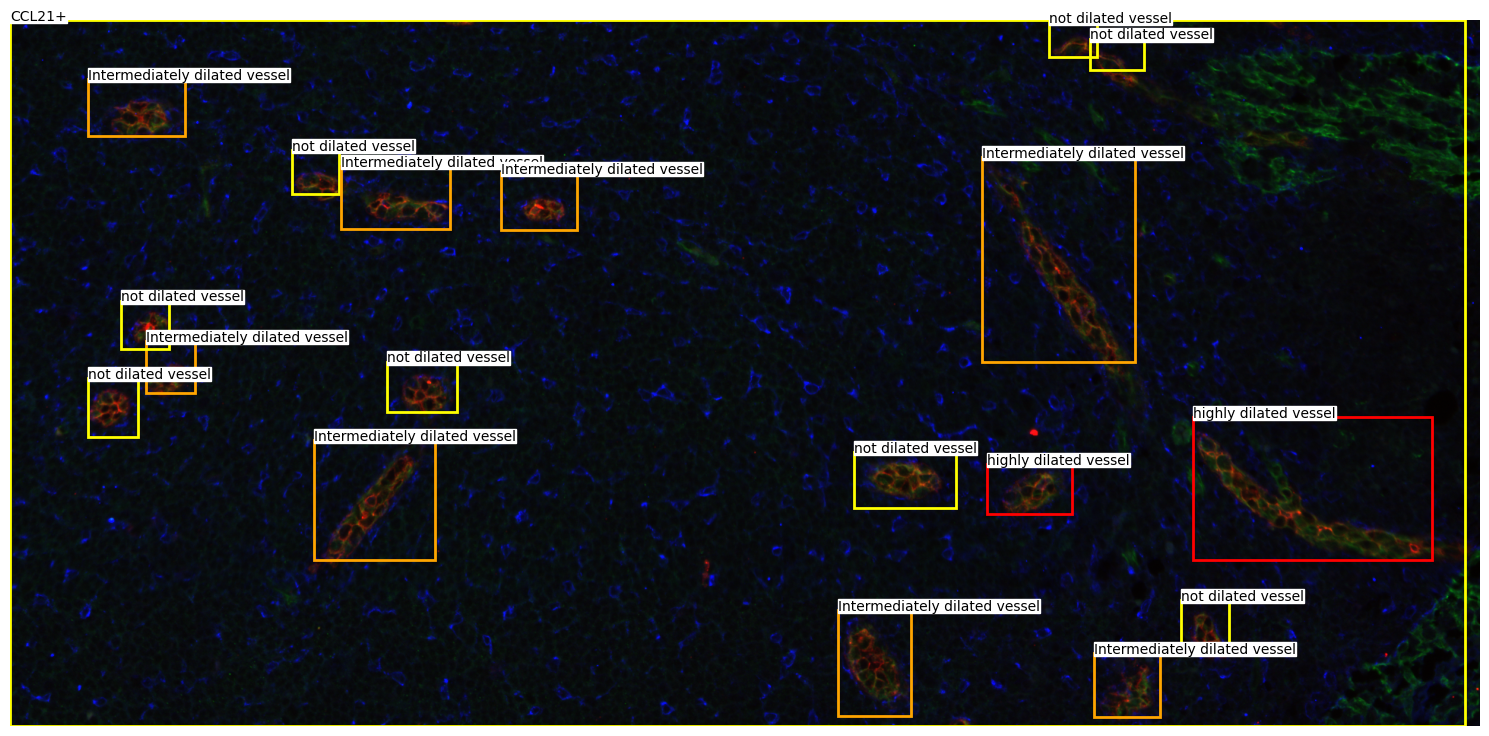

In [24]:
color_list = ["red", "yellow", "orange"]*10 # define a list of colors for drawing bounding boxes

fig, ax = plt.subplots(figsize=(15,10))

for ann in anns:
        bbox = ann['bbox']
        x, y, w, h = [int(b) for b in bbox]
        class_id = ann["category_id"]
        class_name = coco.loadCats(class_id)[0]["name"]
        color_ = color_list[class_id]
        rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor=color_, facecolor='none')

        t_box = ax.text(x, y, class_name,  color='black', fontsize=10)
        t_box.set_bbox(dict(boxstyle='square, pad=0',facecolor='white', alpha=1, edgecolor='white'))
        ax.add_patch(rect)

ax.axis('off')
ax.imshow(im)
ax.set_xlabel('Longitude')


#plt.savefig('2_with_bb.png',pad_inches=0)
plt.tight_layout()
plt.show()